# Explore proteins and complexes of Protein-Constrained RBC model

## Setup 
### Import packages

In [1]:
from collections import defaultdict
from pathlib import Path

import gurobipy as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rbc_gem_utils import (COBRA_CONFIGURATION, PROCESSED_PATH, ROOT_PATH,
                           build_string, read_cobra_model, show_versions)
from rbc_gem_utils.analysis.overlay import (DEFAULT_ENZYME_FORWARD_SUFFIX,
                                            DEFAULT_ENZYME_REVERSE_SUFFIX,
                                            DEFAULT_ENZYME_TOTAL_SUFFIX,
                                            Complex, Enzyme, Protein,
                                            calculate_protein_molar_mass,
                                            load_overlay_model)

gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)

# Show versions of notebook
show_versions()

Set parameter Username

Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Informat

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION.solver = "gurobi"
COBRA_CONFIGURATION.bounds = (-1e3, 1e3)
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Load RBC-GEM models

In [3]:
model_id = "RBC3P"

data_path = Path(f"{ROOT_PATH}/data/analysis/OVERLAY").resolve()
results_path = Path(f"{ROOT_PATH}{PROCESSED_PATH}/{model_id}/OVERLAY")
results_path.mkdir(exist_ok=True, parents=True)

imagetype = "svg"
transparent = True
save_figures = True

model_dirpath = Path(f"{data_path}/{model_id}")
model = read_cobra_model(filename=f"{model_dirpath}/{model_id}.xml")
pcmodel = load_overlay_model(filename=f"{model_dirpath}/{model_id}_PC.xml")
pcmodel

Name,RBC3P_PC
Memory address,15296c050
Number of metabolites,431
Number of reactions,877
Number of genes,103
Number of groups,10
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


### Load RBC-GEM proteins
#### Molar mass distribution of proteins

In [4]:
data = {}
# Conversion factor: mg/nmol --> kg / mol
cf = 1e3
for idx, protein in enumerate(
    pcmodel.metabolites.query(lambda x: isinstance(x, Protein))
):
    reaction = pcmodel.reactions.get_by_id(f"PROTDL_{protein.id}")
    for met, coeff in reaction.metabolites.items():
        if met == protein:
            if "budget" in reaction.reaction:
                continue
            print(
                f"{protein.id} not in proteome budget, calculating mass from sequence annotation"
            )
            coeff = calculate_protein_molar_mass(
                protein.annotation.get("uniprot.aa_sequence", "")
            )
        data[idx] = {
            "protein": protein.id.replace(f"_{protein.compartment}", ""),
            "uniprot": protein.annotation.get("uniprot"),
            "molar_mass": coeff * cf,
        }
df_molar_mass = pd.DataFrame.from_dict(data, orient="index")
df_molar_mass

,protein,uniprot,molar_mass
0,protein_ADA,P00813,40.753998
1,protein_ADK,P55263,40.541038
2,protein_AK1,P00568,21.637678
3,protein_ALDOA,P04075,39.422685
4,protein_ALDOB,P05062,39.474700
...,...,...,...
98,protein_TMEM109,Q9BVC6,26.218790
99,protein_TPI1,P60174,26.668234
100,protein_TRPC6,Q9Y210,106.317376
101,protein_TRPV2,Q9Y5S1,85.964227


Max x-value: 286
Max y-value: 22
[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300.]


array([ 0., 14., 10., 22., 16., 16.,  7.,  0.,  5.,  1.,  3.,  3.,  0.,
        2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  2.,  0.])

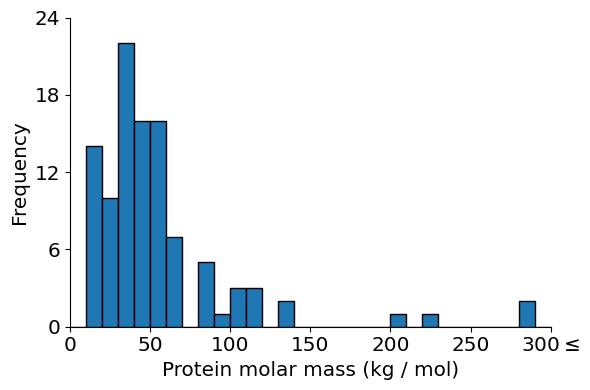

In [5]:
df = df_molar_mass.copy()
max_mass = 300
key = "molar_mass"


xinterval = 10
max_value = np.ceil(df[key].max() / xinterval) * xinterval

if model_id == "RBC_GEM":
    bins = int(max_value / xinterval) + 1
    yinterval = None

else:
    bins = int(max_value / xinterval) + 1
    yinterval = 6

xmin, xmax = (0, max_value)
print(f"Max x-value: {int(df[key].max())}")
counts, bins = np.histogram(
    df[key].values,
    range=(xmin, xmax + xinterval),
    bins=bins,
)

df = pd.DataFrame.from_dict(dict(zip(bins, counts)), orient="index")
if max_mass is not None:
    df.index = [float(idx) if idx < max_mass else max_mass for idx in df.index]
    df = df.groupby(df.index).sum()
    df = df.iloc[:, 0].to_dict()
    bins, counts = list(df.keys()), list(df.values())
    bins.extend([bins[-1] + xinterval])
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.despine(fig)

counts, bins, bars = ax.hist(
    bins[:-1], bins, weights=counts, edgecolor="k", linewidth=1
)
# X-axis
ax.set_xlim((bins[0], bins[-1]))
ax.set_xlabel("Protein molar mass (kg / mol)", fontdict={"size": "x-large"})
if max_mass is not None:
    xticks = np.arange(0, max_mass + (xinterval * 5), (xinterval * 5))
    ax.set_xticks(
        xticks, labels=[x if x != xticks[-1] else f"{x}$\leq$" for x in xticks]
    )
ax.xaxis.set_tick_params(labelsize="x-large")
# Y-axis
y_maxval = int(max(counts))
print(f"Max y-value: {int(y_maxval)}")
print(bins)
if yinterval is not None:
    ax.set_yticks(
        np.arange(0, (yinterval + 1) * np.ceil(y_maxval / yinterval), yinterval)
    )
ax.set_ylabel("Frequency", fontdict={"size": "x-large"})
ax.yaxis.set_tick_params(labelsize="x-large")

# # Additional
# ax.set_title(f"Molar Mass Distribution", fontdict={"size": "x-large"})
fig.tight_layout()
if save_figures:
    fig.savefig(
        f"{results_path}/ProteinMolarMassDistribution_{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
counts

### Load RBC-GEM complexes
#### Identify assumed monomers

In [6]:
df_complexes = pd.read_csv(
    f"{data_path}/pcmodel_complexes.tsv", sep="\t", index_col=None
)
df_assumed_monomer = df_complexes[df_complexes["notes"] == "ASSUMED MONOMER"]["complex"]
all_assumed_monomers_set = {x.replace("cplx_", "") for x in df_assumed_monomer.unique()}
all_assumed_monomers_set;

#### Number of subunits per complex

In [7]:
max_subunit = None

ordered_complex_types = {
    1: "MONOMER",
    2: "DIMER",
    3: "TRIMER",
    4: "TETRAMER",
    5: "PENTAMER",
    6: "HEXAMER",
    7: "HEPTAMER",
    8: "OCTAMER",
    9: "NONAMER",
    10: "DECAMER",
    11: "UNDECAMER",
    12: "DODECAMER",
    13: "TRIDECAMER",
    14: "TETRADECAMER",
    15: "PENTADECAMER",
    16: "HEXADECAMER",
}


data = {}
assumed_monomers = []
for idx, cplx in enumerate(pcmodel.metabolites.query(lambda x: isinstance(x, Complex))):
    cplx_id = cplx.id.split("_", maxsplit=1)[-1].rsplit("_", maxsplit=1)[0]
    cplx_type = cplx_id.split("_")[0]
    reaction = pcmodel.reactions.get_by_id(f"CPLXFM_{cplx.id}")

    data[cplx_id] = {
        "subunits": int(
            sum(abs(np.array(list(reaction.get_coefficients(reaction.reactants)))))
        ),
        "identical_subunits": len(reaction.reactants) == 1,
    }
    if cplx_id in all_assumed_monomers_set:
        assumed_monomers.append(cplx_id)

df = (
    pd.DataFrame.from_dict(data, orient="index")
    .groupby(["subunits", "identical_subunits"])
    .value_counts()
)
df = df.reset_index(drop=False)
df = (
    pd.concat(
        (
            df[df["identical_subunits"]].set_index("subunits")["count"],
            df[~df["identical_subunits"]].set_index("subunits")["count"],
            df.groupby("subunits")["count"].sum(),
        ),
        axis=1,
    )
    .fillna(0)
    .astype(int)
)

max_subunit = max(ordered_complex_types) if max_subunit is None else max_subunit
df.index = [
    idx if idx < max_subunit else rf"{str(max_subunit)}$\leq$" for idx in df.index
]
df_totals = df.groupby(df.index).sum()
df_totals.columns = ["Homomeric", "Heteromeric", "Total"]
print(f"Number of assumed monomers: {len(assumed_monomers)}")
df_totals

Number of assumed monomers: 5


,Homomeric,Heteromeric,Total
1,28,0,28
2,28,12,40
3,5,21,26
4,28,14,42
7,1,0,1


Max y-value: 28
[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300.]


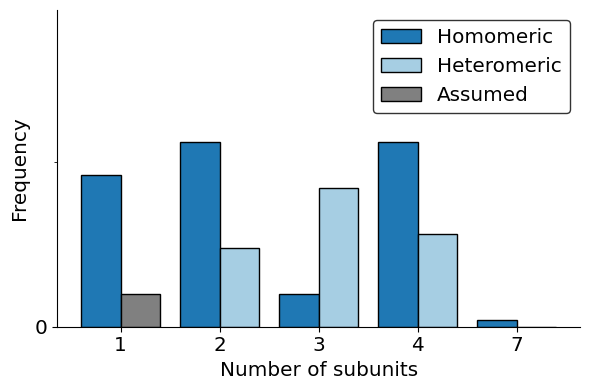

In [8]:
df = df_totals.copy()

assumed_label = "Assumed"
columns_to_plot = ["Homomeric", "Heteromeric"]

df = df[columns_to_plot].copy()
df.iloc[0, 0] -= len(assumed_monomers)
df.iloc[0, 1] += len(assumed_monomers)
colormaps_dict = {
    columns_to_plot[0]: mpl.colormaps["Paired"](1),
    columns_to_plot[1]: mpl.colormaps["Paired"](0),
    assumed_label: "grey",
}

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.despine(fig)

assumed_color = "red"
barsize = 1
edgecolor = "black"
edgewidth = 1
padding = 0.5
offset = np.zeros(len(df.index))
df.index = df.index.astype(str)
y_maxval = 0

scalar = 1
for idx, (label, series) in enumerate(df[columns_to_plot].items()):
    rects = ax.bar(
        np.arange(len(series.index))
        * ((len(columns_to_plot) + padding) * scalar * barsize)
        + ((idx * scalar) * barsize),
        series.values,
        width=barsize,
        label=series.index,
        # bottom=offset,
        color=colormaps_dict.get(label),
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    y_maxval = max(y_maxval, series.max())
    # ax.bar_label(rects, fontsize=10)
    # offset += series.values
    if idx == len(df.columns) - 1:
        rects[0].set_facecolor(colormaps_dict.get(assumed_label))


ax.legend(
    handles=[
        mpl.patches.Patch(facecolor=color, edgecolor=edgecolor)
        for color in list(colormaps_dict.values())
    ],
    ncol=1,
    labels=list(colormaps_dict.keys()),
    frameon=True,
    fancybox=True,
    fontsize="x-large",
    edgecolor="black",
    loc="upper right",
)

# X-axis
ax.set_xticks(
    np.arange(len(series.index)) * ((len(columns_to_plot) + padding) * scalar * barsize)
    + ((idx * scalar) * barsize) / 2,
    labels=series.index,
)
ax.set_xlabel("Number of subunits", fontdict={"size": "x-large"})
ax.xaxis.set_tick_params(labelsize="x-large")
# Y-axis
yinterval = 50
print(f"Max y-value: {int(y_maxval)}")
print(bins)
if yinterval is not None:
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(yinterval))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(yinterval / 2))
    ax.set_ylim(0, round(yinterval * np.ceil(y_maxval / yinterval) * 0.95))
else:
    ax.set_ylim(0, round(y_maxval * 1.1))
ax.set_ylabel("Frequency", fontdict={"size": "x-large"})
ax.yaxis.set_tick_params(labelsize="x-large")
# Additional
# ax.set_title("Complex Composition", fontdict={"size": "xx-large"})
fig.tight_layout()
if save_figures:
    fig.savefig(
        f"{results_path}/ComplexComposition_{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

In [9]:
# df = df_totals.copy()

# assumed_label = "Assumed"
# columns_to_plot = ["Homomeric", "Heteromeric"]
# y_maxval = df_totals["Total"].max()
# df = df[columns_to_plot].copy()
# df.iloc[0, 0] -= len(assumed_monomers)
# df.iloc[0, 1] += len(assumed_monomers)
# colormaps_dict = {
#     columns_to_plot[0]: mpl.colormaps["Paired"](1),
#     columns_to_plot[1]: mpl.colormaps["Paired"](0),
#     assumed_label: "grey",
# }

# fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# sns.despine(fig)

# assumed_color = "red"
# barsize = 0.5
# edgecolor = "black"
# edgewidth = 1
# padding = 2
# offset = np.zeros(len(df.index))
# df.index = df.index.astype(str)
# for idx, (label, series) in enumerate(df[columns_to_plot].items()):

#     rects = ax.bar(
#         series.index,
#         series.values,
#         width=barsize,
#         bottom=offset,
#         color=colormaps_dict.get(label),
#         edgecolor=edgecolor,
#         linewidth=edgewidth,
#     )
#     offset += series.values
#     if idx == len(df.columns) - 1:
#         rects[0].set_facecolor(colormaps_dict.get(assumed_label))

# # ax.bar_label(
# #     rects,
# #     labels=df.apply(lambda x: "|".join(x.astype(str)), axis=1),
# #     label_type="edge",
# #     color="black",
# #     padding=padding,
# #     fontsize="medium",
# # )
# ax.legend(
#     handles=[
#         mpl.patches.Patch(facecolor=color, edgecolor=edgecolor)
#         for color in list(colormaps_dict.values())
#     ],
#     ncol=1,
#     labels=list(colormaps_dict.keys()),
#     frameon=True,
#     fancybox=True,
#     fontsize="x-large",
#     edgecolor="black",
#     loc="best",
# )
# # X-axis
# ax.set_xlabel("Number of subunits", fontdict={"size": "x-large"})
# ax.xaxis.set_tick_params(labelsize="x-large")
# # Y-axis
# yinterval = 100
# print(f"Max y-value: {int(y_maxval)}")
# print(bins)
# if yinterval is not None:
#     ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(yinterval))
#     ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(yinterval/2))
#     ax.set_ylim(0, yinterval * np.ceil(y_maxval / yinterval) * 0.95)
# else:
#     ax.set_ylim(0, y_maxval * 1.1)
# ax.set_ylabel("Frequency", fontdict={"size": "x-large"})
# ax.yaxis.set_tick_params(labelsize="x-large")
# # Additional
# # ax.set_title("Complex Composition", fontdict={"size": "xx-large"})
# fig.tight_layout()
# if save_figures:
#     fig.savefig(
#         f"{results_path}/ComplexCompositionStacked_{model_id}.{imagetype}",
#         transparent=transparent,
#         format=imagetype,
#     )

#### Complex effective rate constants

In [10]:
seperate_forward_and_reverse_rate_constants = True
enzyme_forward_suffix = DEFAULT_ENZYME_FORWARD_SUFFIX
enzyme_reverse_suffix = DEFAULT_ENZYME_REVERSE_SUFFIX

enzfms = [
    tuple(x.id.split("_cplx_"))
    for x in pcmodel.reactions.query(lambda x: x.id.startswith("ENZFM_"))
]
enzfms = sorted(
    set(
        [
            (
                x[0]
                .replace(enzyme_forward_suffix, "")
                .replace(enzyme_reverse_suffix, ""),
                x[1],
            )
            for x in enzfms
        ]
    )
)
total_possible_enzforms = len(enzfms) * 2

data = {}
count = 0
for enzyme in pcmodel.metabolites.query(lambda x: isinstance(x, Enzyme)):
    enzyme_id = enzyme.id.rsplit("_", maxsplit=1)[0]
    if enzyme_id.endswith(enzyme_forward_suffix):
        enz_var = enzyme_id.replace(enzyme_forward_suffix, "")
        reaction_id = enz_var.split("_", maxsplit=1)[1]
        direction = "forward"
    elif enzyme_id.endswith(enzyme_reverse_suffix):
        enz_var = enzyme_id.replace(enzyme_reverse_suffix, "")
        reaction_id = enz_var.split("_", maxsplit=1)[1]
        direction = "reverse"
    else:
        continue
    enzyme_rxn = pcmodel.reactions.get_by_id(reaction_id)
    enzyme_keff = 1 / abs(enzyme_rxn.get_coefficient(enzyme.id)) / 1e-6
    enzyme_form_rxns = pcmodel.reactions.query(
        lambda x: x.id.startswith(
            "ENZFM_{}".format(enzyme.id.replace(f"_{enzyme.compartment}", ""))
        )
    )
    for reaction in enzyme_form_rxns:
        for cplx in reaction.reactants:
            data[count] = {
                "enzyme": enz_var,
                "enzymes": enzyme.id,
                "complexes": cplx.id,
                "complex_keff": enzyme_keff * abs(reaction.get_coefficient(cplx)),
                "complex_keff / enzyme_keff": abs(reaction.get_coefficient(cplx)),
                "enzyme_keff": enzyme_keff,
            }
            count += 1

df_keffs = pd.DataFrame.from_dict(data, orient="index")

irrev_keffs = {}
count = 0
for enzfm in list(enzfms):
    compartment = enzfm[1].rsplit("_", -1)[-1]
    enz_var = enzfm[0].replace("ENZFM_", "")
    enzyme_id = f"{enz_var}{enzyme_forward_suffix}_{compartment}"
    complex_id = f"cplx_{enzfm[1]}"
    if not pcmodel.reactions.has_id(f"{enzfm[0]}{enzyme_forward_suffix}_{complex_id}"):
        enzyme_keff = df_keffs.set_index(["enzymes", "complexes"]).loc[
            (f"{enz_var}{enzyme_reverse_suffix}_{compartment}", complex_id),
            "enzyme_keff",
        ]
        irrev_keffs[count] = {
            "enzyme": enz_var,
            "enzymes": enzyme_id,
            "complexes": complex_id,
            "complex_keff": 0,
            "complex_keff / enzyme_keff": 0,
            "enzyme_keff": enzyme_keff,
        }
        count += 1
    enzyme_id = f"{enz_var}{enzyme_reverse_suffix}_{compartment}"
    if not pcmodel.reactions.has_id(f"{enzfm[0]}{enzyme_reverse_suffix}_{complex_id}"):
        enzyme_keff = df_keffs.set_index(["enzymes", "complexes"]).loc[
            (f"{enz_var}{enzyme_forward_suffix}_{compartment}", complex_id),
            "enzyme_keff",
        ]
        irrev_keffs[count] = {
            "enzyme": enz_var,
            "enzymes": enzyme_id,
            "complexes": complex_id,
            "complex_keff": 0,
            "complex_keff / enzyme_keff": 0,
            "enzyme_keff": enzyme_keff,
        }
        count += 1

irrev_keffs = pd.DataFrame.from_dict(irrev_keffs, orient="index")

df_keffs = pd.concat(
    (
        df_keffs,
        irrev_keffs,
    ),
    axis=0,
)
df_keffs = df_keffs.groupby(["enzyme", "enzymes", "complexes"], as_index=False).agg(
    lambda x: list(x.unique()).pop()
)
if not seperate_forward_and_reverse_rate_constants:
    df_keffs = df_keffs.drop("enzymes", axis=1)
    df_keffs = df_keffs.groupby(["enzyme", "complexes"], as_index=False).agg(
        lambda x: [v for v in x.unique() if v != 0][0]
    )
    df_keffs = df_keffs.sort_values(by=["enzyme", "complexes"])
else:
    df_keffs = df_keffs.sort_values(by=["enzyme", "complexes", "enzymes"])
df_keffs["complex_keff"] *= 1 / 3600
df_keffs["enzyme_keff"] *= 1 / 3600
df_keffs

KeyError: ('enzyme_ADA_rev_pc', 'cplx_MONOMER_ADA_pc')

Max x-value: 450.0
Max y-value: 234


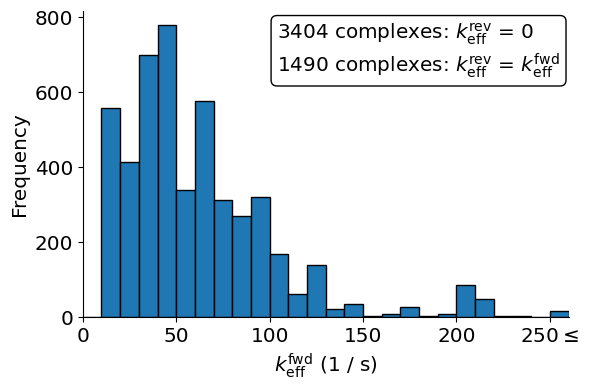

In [11]:
max_keff_value = 250
include_zero_keff = False

key = "complex_keff"

df = df_keffs[
    df_keffs["enzymes"].apply(lambda x: x.endswith(f"{enzyme_reverse_suffix}_pc"))
]
nzero_keff = len(df[df[key] == 0])
fwd_is_rev = len(df[df[key] != 0])
df = df_keffs[
    df_keffs["enzymes"].apply(lambda x: x.endswith(f"{enzyme_forward_suffix}_pc"))
]


xinterval = 10
yinterval = None
max_value = np.ceil(df[key].max() / xinterval) * xinterval


bins = int(max_value / xinterval) + 1
xmin, xmax = (0, max_value)
print(f"Max x-value: {max_value}")
counts, bins = np.histogram(
    df[key].values,
    range=(xmin, xmax + xinterval),
    bins=bins,
)

df = pd.DataFrame.from_dict(dict(zip(bins, counts)), orient="index")
if max_keff_value is not None:
    df.index = [
        float(idx) if idx < max_keff_value else max_keff_value for idx in df.index
    ]
    df = df.groupby(df.index).sum()
    df = df.iloc[:, 0].to_dict()
    bins, counts = list(df.keys()), list(df.values())
    bins.extend([bins[-1] + xinterval])


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.despine(fig)

counts, bins, bars = ax.hist(
    bins[:-1], bins, weights=counts, edgecolor="k", linewidth=1
)
# X-axis
ax.set_xlim(bins[0], bins[-1])
ax.set_xlabel(r"$k^\mathrm{fwd}_\mathrm{eff}$ (1 / s)", fontdict={"size": "x-large"})
if max_keff_value is not None:
    xticks = np.arange(0, max_keff_value + (xinterval * 5), (xinterval * 5))
    ax.set_xticks(
        xticks, labels=[x if x != xticks[-1] else f"{x}$\leq$" for x in xticks]
    )
ax.xaxis.set_tick_params(labelsize="x-large")
# Y-axis
print(f"Max y-value: {int(y_maxval)}")
if yinterval is not None:
    ax.set_yticks(
        np.arange(0, (yinterval + 1) * np.ceil(y_maxval / yinterval), yinterval)
    )

ax.set_ylabel("Frequency", fontdict={"size": "x-large"})
ax.yaxis.set_tick_params(labelsize="x-large")
# Additional
# ax.set_title(r"Complex $k_\mathrm{eff}$ Distribution", fontdict={"size": "x-large"})
if nzero_keff is not None:
    n_total = df_keffs[["enzyme", "complexes"]].drop_duplicates()
    ax.annotate(
        "\n".join(
            (
                f"{nzero_keff} complexes: " + r"$k^\mathrm{rev}_\mathrm{eff}$ = 0",
                f"{fwd_is_rev} complexes: "
                + r"$k^\mathrm{rev}_\mathrm{eff}$ = $k^\mathrm{fwd}_\mathrm{eff}$",
            )
        ),
        xy=(0.4, 0.8),
        ha="left",
        xycoords=ax.transAxes,
        fontsize="x-large",
        bbox=dict(facecolor="none", edgecolor="black", boxstyle="round"),
    )

fig.tight_layout()
if save_figures:
    fig.savefig(
        f"{results_path}/ComplexKeffDistribution_{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Systemic "enzyme" effective rate constants

In [12]:
# dataframes = {
#     "Estimated from mass": df_keffs.copy(),
# }

# max_value = 250
# key = "enzyme_keff"
# if max_value is not None:
#     df = dataframes["Estimated from mass"]
#     df.loc[df[df[key].values > max_value].index, key] = max_value
#     dataframes["Estimated from mass"] = df

# bins = 41
# xinterval = 1
# yinterval = 5

# fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# sns.despine(fig)

# xmin, xmax = (0, xinterval * round(max_value) / xinterval)
# print(f"Max x-value: {max_value}")
# for label, dataframe in dataframes.items():
#     counts, bins = np.histogram(
#         dataframe[key].values,
#         range=(xmin, xmax + xinterval),
#         bins=bins,
#     )

#     counts, bins, bars = ax.hist(
#         bins[:-1],
#         bins,
#         weights=counts,
#         alpha=0.5,
#         edgecolor="k",
#         linewidth=1,
#         label=label,
#     )

# # X-axis
# ax.set_xlim((xmin, xmax + xinterval))
# ax.set_xlabel(r"$k_\mathrm{eff}$ (1 / s)", fontdict={"size": "x-large"})
# ax.xaxis.set_tick_params(labelsize="x-large")
# # Y-axis
# # if yinterval is not None and y_maxval is not None:
# #     ax.set_yticks(np.arange(0, (yinterval + 1) * np.ceil(y_maxval / yinterval), yinterval))
# # ax.set_ylabel("Frequency", fontdict={"size": "x-large"})
# ax.yaxis.set_tick_params(labelsize="x-large")
# ax.legend(
#     loc="upper right",
#     fontsize="x-large",
#     frameon=False,
# )
# # Additional
# ax.set_title(r"Enzyme $k_\mathrm{eff}$ Distribution", fontdict={"size": "x-large"})
# fig.tight_layout()
# if save_figures:
#     fig.savefig(
#         f"{results_path}/EnzymeKeffDistribution_{model_id}.{imagetype}",
#         transparent=transparent,
#         format=imagetype,
#     )

#### Compare to model with curated effective rate constants

In [13]:
# try:
#     pcmodel_curated = load_overlay_model(filename=f"{model_dirpath}/{model_id}_PC_keff_curated.xml")
# except FileNotFoundError:
#     pass
# pcmodel_curated

In [14]:
# data = {}
# count = 0
# for enzyme in pcmodel_curated.metabolites.query(lambda x: isinstance(x, Enzyme)):
#     enzyme_id = enzyme.id.rsplit("_", maxsplit=1)[0]
#     if enzyme_id.endswith("rev"):
#         reaction_id = enzyme_id.replace("_rev", "").split("_", maxsplit=1)[1]
#     else:
#         reaction_id = enzyme_id.split("_", maxsplit=1)[1]
#     enzyme_rxn = pcmodel_curated.reactions.get_by_id(reaction_id)
#     enzyme_keff = 1 / abs(enzyme_rxn.get_coefficient(enzyme.id)) / 1e-6
#     enzyme_form_rxns = pcmodel_curated.reactions.query(lambda x: x.id.startswith("ENZFM_{}".format(enzyme.id.replace(f"_{enzyme.compartment}", ""))))
#     for reaction in enzyme_form_rxns:
#         for cplx in reaction.reactants:
#             data[count] = {
#                 "enzyme": enzyme.id,
#                 "complexes": cplx.id,
#                 "complex_keff": enzyme_keff * abs(reaction.get_coefficient(cplx)),
#                 "complex_keff / enzyme_keff": abs(reaction.get_coefficient(cplx)),
#                 "enzyme_keff": enzyme_keff,
#             }
#             count += 1

# df_keffs_curated = pd.DataFrame.from_dict(data, orient="index")
# df_keffs_curated = df_keffs_curated.groupby(["enzyme", "complexes"], as_index=False).agg(lambda x: list(x.unique()).pop())
# df_keffs_curated["complex_keff"] *= 1 / 3600
# df_keffs_curated["enzyme_keff"] *= 1 / 3600
# df_keffs_curated

In [15]:
# dataframes = {
#     "Estimated from mass": df_keffs.copy(),
#     "Curated from literature": df_keffs_curated.copy(),
# }

# max_value = 250
# key = "complex_keff"
# if max_value is not None:
#     df = dataframes["Estimated from mass"]
#     df.loc[df[df[key].values > max_value].index, key] = max_value
#     dataframes["Estimated from mass"] = df

#     df = dataframes["Curated from literature"]
#     df.loc[df[df[key].values > max_value].index, key] = max_value
#     dataframes["Curated from literature"] = df

# bins = 41
# xinterval = 1
# yinterval = 5

# fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# sns.despine(fig)

# xmin, xmax = (0, xinterval * round(max_keff) / xinterval)
# print(f"Max x-value: {max_keff}")
# for label, dataframe in dataframes.items():
#     counts, bins = np.histogram(
#         dataframe[key].values,
#         range=(xmin, xmax + xinterval),
#         bins=bins,
#     )

#     counts, bins, bars = ax.hist(
#         bins[:-1],
#         bins,
#         weights=counts,
#         alpha=0.5,
#         edgecolor="k",
#         linewidth=1,
#         label=label,
#     )

# # X-axis
# ax.set_xlim((xmin, xmax + xinterval))
# ax.set_xlabel("$k_\mathrm{eff}$ (1 / s)", fontdict={"size": "x-large"})
# ax.xaxis.set_tick_params(labelsize="large")
# # Y-axis

# if yinterval is not None and y_maxval is not None:
#     ax.set_yticks(np.arange(0, (yinterval + 1) * np.ceil(y_maxval / yinterval), yinterval))
# ax.set_ylabel("Frequency", fontdict={"size": "x-large"})
# ax.yaxis.set_tick_params(labelsize="large")
# ax.legend(
#     loc="upper right",
#     fontsize="x-large",
#     frameon=False,
# )
# # Additional
# ax.set_title("Complex $k_\mathrm{eff}$ Distribution", fontdict={"size": "x-large"})
# fig.tight_layout()
# if save_figures:
#     fig.savefig(
#         f"{results_path}/ComplexKeffDistributionCompare_{model_id}.{imagetype}",
#         transparent=transparent,
#         format=imagetype,

#     )

In [16]:
# dataframes = {
#     "Estimated from mass": df_keffs.copy(),
#     "Curated from literature": df_keffs_curated.copy(),
# }

# max_value = 220
# key = "enzyme_keff"
# if max_value is not None:
#     df = dataframes["Estimated from mass"]
#     df = df.loc[df[df[key] < max_value].index]

#     df = dataframes["Curated from literature"]
#     df = df.loc[df[df[key] < max_value].index]

# bins = 41
# xinterval = 1
# yinterval = 5

# fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# sns.despine(fig)

# xmin, xmax = (0, xinterval * round(max_keff) / xinterval)
# print(f"Max x-value: {max_keff}")
# for label, dataframe in dataframes.items():
#     counts, bins = np.histogram(
#         dataframe[key].values,
#         range=(xmin, xmax + xinterval),
#         bins=bins,
#     )

#     counts, bins, bars = ax.hist(
#         bins[:-1],
#         bins,
#         weights=counts,
#         alpha=0.5,
#         edgecolor="k",
#         linewidth=1,
#         label=label,
#     )

# # X-axis
# ax.set_xlim((xmin, xmax + xinterval))
# ax.set_xlabel("$k_\mathrm{eff}$ (1 / s)", fontdict={"size": "x-large"})
# ax.xaxis.set_tick_params(labelsize="large")
# # Y-axis

# if yinterval is not None and y_maxval is not None:
#     ax.set_yticks(np.arange(0, (yinterval + 1) * np.ceil(y_maxval / yinterval), yinterval))
# ax.set_ylabel("Frequency", fontdict={"size": "x-large"})
# ax.yaxis.set_tick_params(labelsize="large")
# ax.legend(
#     loc="upper right",
#     fontsize="x-large",
#     frameon=False,
# )
# # Additional
# ax.set_title("Complex $k_\mathrm{eff}$ Distribution", fontdict={"size": "x-large"})
# fig.tight_layout()
# if save_figures:
#     fig.savefig(
#         f"{results_path}/EnzymeKeffDistributionCompare_{model_id}.{imagetype}",
#         transparent=transparent,
#         format=imagetype,

#     )